## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from matplotlib import rcParams

from statsmodels.graphics import tsaplots
import statsmodels.api as sm

## Set Computational Device

In [2]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)

cpu


## Data Pre-Processing

#### Import Data

In [3]:
# data = pd.read_csv('../data/ECONOMICS_USCSHPIMM, 1M.csv')

In [4]:
data = pd.read_csv('ECONOMICS_USCSHPIMM, 1M.csv')

#### Inspect and Reshape Data

In [5]:
# Check layout
data.head()

,time,close
0,949363200,0.8
1,951868800,1.2
2,954547200,1.5
3,957139200,1.6
4,959817600,1.5


In [6]:
# Check for missing data points
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    294 non-null    int64  
 1   close   294 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.7 KB


In [7]:
# Convert time to datetime
data['time'] = pd.to_datetime(data['time'], unit = 's')
data = data.set_index('time')
data.head()

,close
time,
2000-02-01,0.8
2000-03-01,1.2
2000-04-01,1.5
2000-05-01,1.6
2000-06-01,1.5


In [8]:
# Convert to Numpy Array for further processing
data_raw = np.array(data).reshape(-1,1)

#### Data Visualization - Plot Data

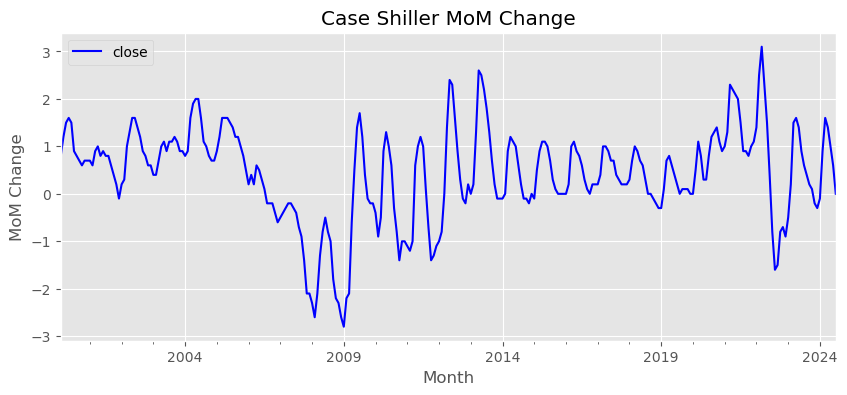

In [9]:
data.plot(figsize=(10, 4),color='blue')
plt.xlabel("Month")
plt.ylabel('MoM Change')
plt.title("Case Shiller MoM Change")
plt.show()

#### Find Seasonal Component

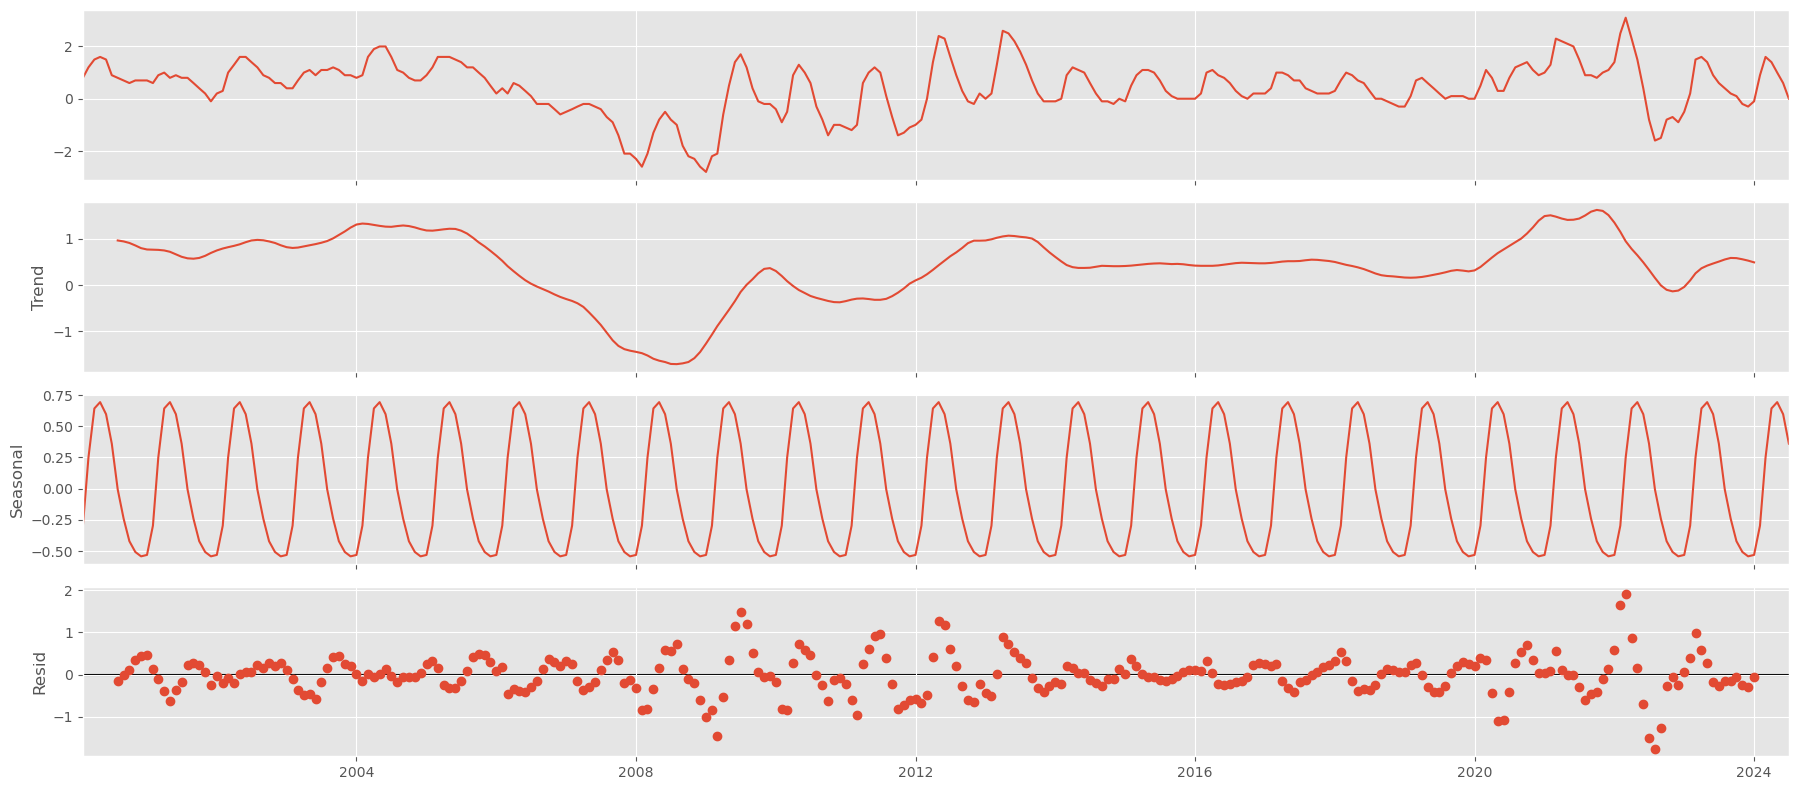

In [10]:
# Time-series decomposition
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive')
fig = decomposition.plot()
plt.show()

In [11]:
# Calculate seasonal component length, used to determine train/test split

seasonal_points = np.array(decomposition.seasonal)
# troughs = np.flatnonzero(seasonal_points == np.min(seasonal_points))
# seasonal_length = troughs[1] - troughs[0]
seasonal_length = np.flatnonzero(seasonal_points == np.min(seasonal_points))[1] - np.flatnonzero(seasonal_points == np.min(seasonal_points))[0]

#### Normalize data

In [12]:
# Choose Scaler to use:
# scaler = StandardScaler()
# scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer()

In [13]:
# Scale Data
data_scaled = scaler.fit_transform(data_raw)
data_scaled.shape

(294, 1)

#### Plot Normalized Data

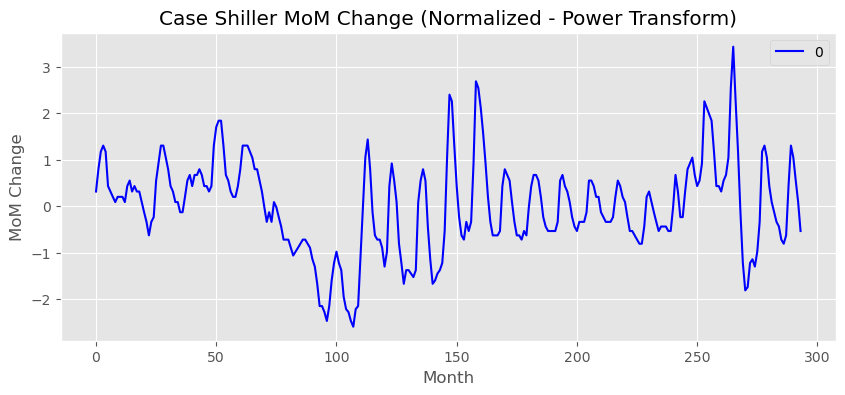

In [14]:
pd.DataFrame(data_scaled).plot(figsize=(10, 4),color='blue')
plt.xlabel("Month")
plt.ylabel('MoM Change')
plt.title("Case Shiller MoM Change (Normalized - Power Transform)")
plt.show()

#### Train/Test Split

In [15]:
# Split data using 2 seasonal cycles of data to predict
cycles_to_predict = 2

# Calculate train/test split
split = len(data) - (cycles_to_predict * seasonal_length )

# Length of sequences to predict
n_input = len(data) - split

# Target sequence values used to calculate performance metrics 
data_targets = data.to_numpy()[split:]

# Create train and test data sets
train_data = data_scaled[:split]
test_data = data_scaled[split:]
print(train_data.shape)
print(test_data.shape)

(270, 1)
(24, 1)


#### Convert to Sequences

In [16]:
# Convert training data into sequences (sliding windows) needed for LSTM. each sequence of 12 the target is the next value, i.e. 13th.
def create_sequences(data, n_input):
    sequences = []
    for i in range(len(data) - n_input):
        seq = data[i:i + n_input]
        label = data[i + n_input]
        sequences.append((seq, label))
    return sequences

train_sequences = create_sequences(train_data, n_input)

# Convert to PyTorch tensors
train_x = torch.tensor([seq[0] for seq in train_sequences], dtype=torch.float32).to(device)
train_y = torch.tensor([seq[1] for seq in train_sequences], dtype=torch.float32).to(device)

/var/folders/tf/xgr43d3x3gv_27t5cflz7xz00000gp/T/ipykernel_44569/983403349.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_68u_j54pu8/croot/pytorch-select_1717607460029/work/torch/csrc/utils/tensor_new.cpp:277.)
  train_x = torch.tensor([seq[0] for seq in train_sequences], dtype=torch.float32).to(device)


## Training Set-up (Shared Across Models)

#### Training Parameters

In [60]:
n_features = 1
batch_size = 10
epochs = 200
n_runs = 3

#### Dataset and Dataloader

In [18]:
# Dataset and DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

#### Train Model Function

In [73]:
def train_model(model, train_loader, epochs):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    # Early Stopping Parameters
    patience = 50
    min_delta = 0.00005
    val_losses = []

    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        scheduler.step(loss)
        if (epoch + 1) % 25 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        
        # Early Stopping Check (maybe go before back propogate a higher loss? i.e. before loss.backward() above)
        if epoch > 10:
            if loss.item() + min_delta >= max(val_losses[-patience:]):
                print(f"Early stopping at Epoch {epoch+1} with loss: {loss.item():.4f}")
                # print(val_losses[-patience:])
                break

        val_losses.append(loss.item())

In [86]:
def train_model(model, train_loader, epochs):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    # Early Stopping Parameters
    patience = 50
    min_delta = 0.00005
    val_losses = []

    for epoch in range(epochs):
        exit_loop = False
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            # Early Stopping Check 
            if epoch > 10 and loss.item() + min_delta >= max(val_losses[-patience:]):
                print(f"Early stopping at Epoch {epoch+1} with loss: {loss.item():.4f}. Last loss used from Epoch {epoch}: {val_losses[-1]}")
                exit_loop = True
                break
            loss.backward()
            optimizer.step()
        
        if exit_loop:
            break

        scheduler.step(loss)
        if (epoch + 1) % 25 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        
        # Early Stopping Check (maybe go before back propogate a higher loss? i.e. before loss.backward() above)
        # if epoch > 10 and loss.item() + min_delta >= max(val_losses[-patience:]):
        #     print(f"Early stopping at Epoch {epoch+1} with loss: {loss.item():.4f}")
        #     exit_loop = True
        #     break

        val_losses.append(loss.item())

#### Performance Evaluation Metrics Function

In [20]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / (y_true+0.001))) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

## Vanilla LSTM

#### Define LSTM Model

In [21]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a probability of 0.2
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        x = torch.relu(self.fc1(lstm_out[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Vanilla LSTM Training

In [87]:
# Averaging over multiple runs (to keep the loop structure like in the original code)
store = np.zeros((n_input, n_runs))

for i in range(n_runs):
    #reset_weights(model)  # Reset the weights to random
    model = LSTMModel(n_input, n_features).to(device)
    train_model(model, train_loader, epochs)
    pred_list = []

    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model(batch).item()
            pred_list.append(pred)
           # Update the batch by appending the prediction and removing the first element
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)

    store[:, i] = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1)).flatten()

# Averaging predictions
final_vanilla = np.mean(store, axis=1)

Epoch [25/200], Loss: 0.5524
Epoch [50/200], Loss: 0.3652
Epoch [75/200], Loss: 0.2493
Early stopping at Epoch 99 with loss: 0.4812. Last loss used from Epoch 98: 0.36765989661216736
Epoch [25/200], Loss: 0.5163
Epoch [50/200], Loss: 0.4900
Epoch [75/200], Loss: 0.3858
Epoch [100/200], Loss: 0.4319
Epoch [125/200], Loss: 0.4406
Early stopping at Epoch 135 with loss: 0.6369. Last loss used from Epoch 134: 0.37169507145881653
Epoch [25/200], Loss: 0.4134
Epoch [50/200], Loss: 0.4134
Epoch [75/200], Loss: 0.4097
Early stopping at Epoch 99 with loss: 0.6617. Last loss used from Epoch 98: 0.2645539343357086


#### Vanilla LSTM Predictions

In [88]:
print(final_vanilla.shape)
print(final_vanilla)

(24,)
[-1.0157288  -0.86866697 -0.82967513 -0.40695612  0.35354794  1.05852464
  1.69237556  1.85790586  1.5457586   0.86717387  0.19680791 -0.34173808
 -0.61251785 -0.73998341 -0.71841711 -0.47359233  0.0821042   0.79451536
  1.3911754   1.62168289  1.41462972  0.86416828  0.22632563 -0.13052993]


#### Export Data

In [30]:
np.savetxt("CSMoM_Vanilla_LSTM_Predictions.csv", final_vanilla, fmt='%f', delimiter=",")

#### Vanilla LSTM Predictions Visualization

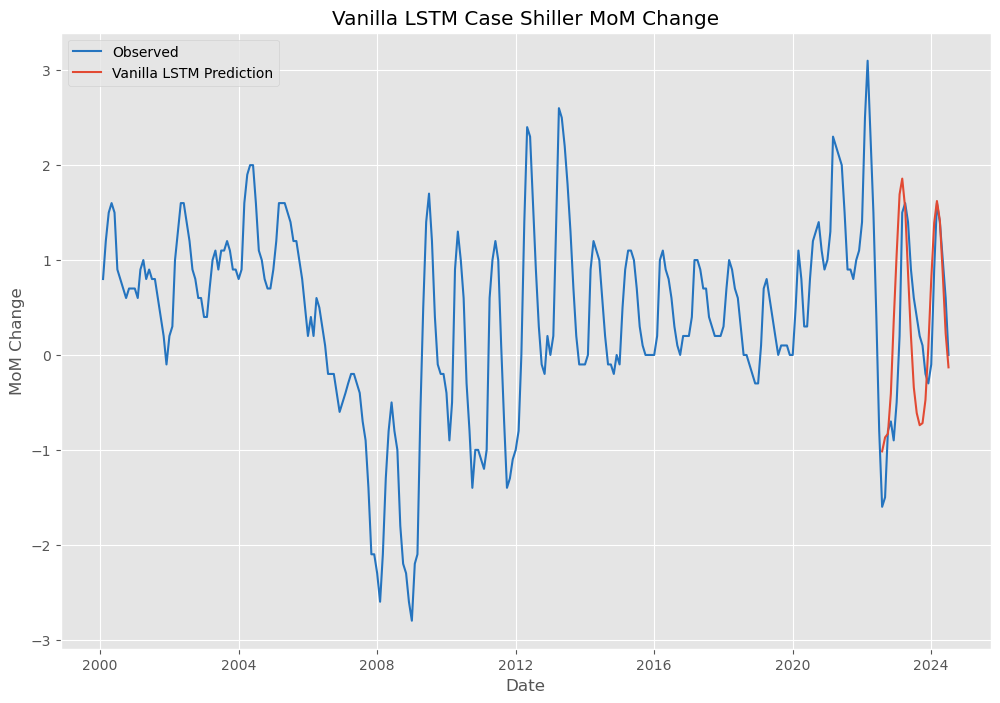

In [89]:
# line plot of observed vs predicted
rcParams['figure.figsize'] = 12, 8
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM Case Shiller MoM Change')
plt.xlabel('Date')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

#### Vanilla LSTM Performance Metrics

In [63]:
vanilla_lstm = performance(data_targets,final_vanilla)
vanilla_lstm

{'MSE': 1.95, 'RMSE': 1.4, 'MAPE': 4182.44}

## Stacked LSTM


#### Define Stacked LSTM Model

In [53]:
# Define the stacked LSTM model
class StackedLSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(StackedLSTMModel, self).__init__()
        # First LSTM layer (returns entire sequences)
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True, dropout=0.2 ,num_layers=2)
        # Second LSTM layer (returns entire sequences)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, batch_first=True)
        #manual dropout
        self.dropout = nn.Dropout(0.2)
        # Fully connected layers
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(lstm_out1)
        x = lstm_out2[:, -1, :]  # Get the last time step output
        #x = self.dropout(x)  # Apply dropout here
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Stacked LSTM Training

In [54]:
# Train and predict multiple times
store2 = np.zeros((n_input, n_runs))

for i in range(n_runs):
    # Initialize the model
    model_stacked = StackedLSTMModel(n_input=n_input, n_features=n_features).to(device)
    
    # Train the model
    train_model(model_stacked, train_loader, epochs)
    
    # Make predictions
    pred_list_s = []
    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model_stacked(batch).item()  # Get prediction
            pred_list_s.append(pred)
            # Update the batch by appending the predicted value
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)


    # Inverse transform the predictions and store them
    store2[:, i] = scaler.inverse_transform(np.array(pred_list_s).reshape(-1, 1)).flatten()

# Average the results across runs (if needed)
final_stacked = np.mean(store2, axis=1)

Epoch [10/200], Loss: 3.0570
Epoch [20/200], Loss: 0.5192
Epoch [30/200], Loss: 0.4218
Epoch [40/200], Loss: 0.2914
Epoch [50/200], Loss: 0.3291
Epoch [60/200], Loss: 0.4977
Early stopping at Epoch 60 with loss: 0.4977
Epoch [10/200], Loss: 3.1642
Epoch [20/200], Loss: 0.4036
Epoch [30/200], Loss: 0.3697
Epoch [40/200], Loss: 0.2565
Epoch [50/200], Loss: 0.0679
Epoch [60/200], Loss: 0.1062
Epoch [70/200], Loss: 0.0734
Epoch [80/200], Loss: 0.0114
Epoch [90/200], Loss: 0.0417
Early stopping at Epoch 94 with loss: 0.1216


#### Stacked LSTM Predictions

In [55]:
print(final_stacked)
print(final_stacked.shape)

[-0.81834718 -0.68238674 -0.66861576 -0.70014619  0.34624215  1.20076309
  1.42650413  1.12856144  0.44239607 -0.3528949  -1.02179224 -1.31282347
 -1.64065857 -1.55540054 -1.51793521 -1.02369237 -0.07029855  0.38255731
  0.42956511 -0.14321455 -0.84534781 -1.45272534 -1.73902799 -1.88671085]
(24,)


#### Export Data

In [67]:
np.savetxt("CSMoM_Stacked_LSTM_Predictions.csv", final_stacked, fmt='%f', delimiter=",")

#### Stacked LSTM Predictions Visualization

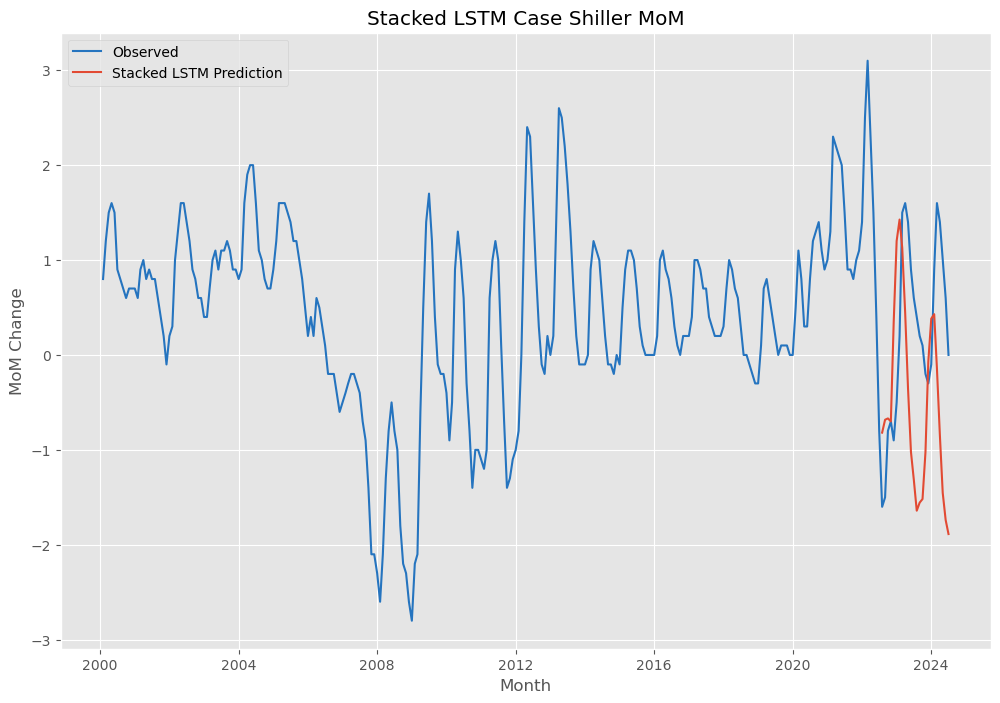

In [56]:
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_stacked,label="Stacked LSTM Prediction")
plt.title('Stacked LSTM Case Shiller MoM')
plt.xlabel('Month')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

#### Stacked LSTM Performance Metrics

In [69]:
stacked_lstm = performance(data_targets,final_stacked)
stacked_lstm

{'MSE': 1.59, 'RMSE': 1.26, 'MAPE': 3364.9}

## Bidirectional LSTM

#### Define Bidirectional LSTM Model


In [70]:
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(BidirectionalLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a probability of 0.2
        self.fc1 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        x = torch.relu(self.fc1(lstm_out[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Bidirectional LSTM Training

In [71]:
# Train and predict multiple times
store3 = np.zeros((n_input, n_runs))

for i in range(n_runs):
    # Initialize the model
    model_bidirec = BidirectionalLSTMModel(n_input=n_input, n_features=n_features).to(device)
    
    # Train the model
    train_model(model_bidirec, train_loader, epochs)
    
    # Make predictions
    pred_list_s = []
    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model_bidirec(batch).item()  # Get prediction
            pred_list_s.append(pred)
            # Update the batch by appending the predicted value
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)


    # Inverse transform the predictions and store them
    store3[:, i] = scaler.inverse_transform(np.array(pred_list_s).reshape(-1, 1)).flatten()

# Average the results across runs (if needed)
final_bidirec = np.mean(store3, axis=1)

Epoch [25/50], Loss: 0.4720
Epoch [50/50], Loss: 0.4424
Epoch [25/50], Loss: 0.4333
Epoch [50/50], Loss: 0.4905
Epoch [25/50], Loss: 0.5594
Epoch [50/50], Loss: 0.4221


#### Bidirectional LSTM Predictions

In [72]:
print(final_bidirec)
print(final_bidirec.shape)

[-0.9238755  -0.8826236  -0.86835673 -0.73159953  0.06637638  0.94041206
  1.56402696  1.69128945  1.17414405  0.54276958 -0.01237713 -0.3650935
 -0.54642156 -0.62638706 -0.60661515 -0.32516548  0.14453429  0.9425014
  1.48947887  1.62604743  1.28982132  0.73919431  0.14221712 -0.19877636]
(24,)


#### Export Data

In [ ]:
np.savetxt("CSMoM_Bidirec_LSTM_Predictions.csv", final_bidirec, fmt='%f', delimiter=",")

#### Bidirectional LSTM Predictions Visualization

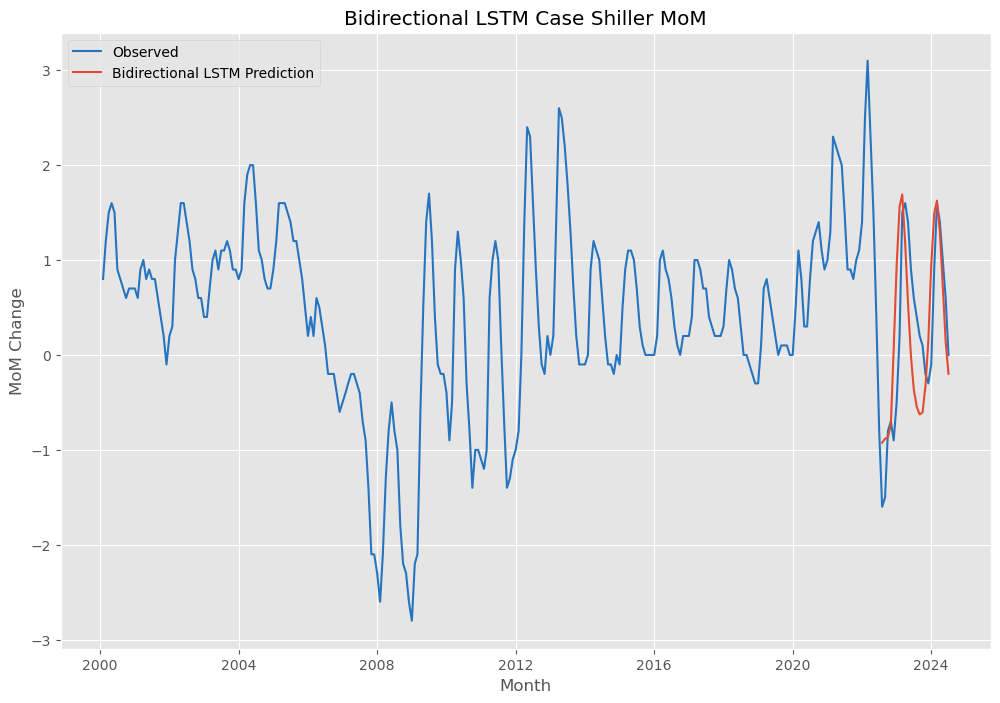

In [73]:
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_bidirec,label="Bidirectional LSTM Prediction")
plt.title('Bidirectional LSTM Case Shiller MoM')
plt.xlabel('Month')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

#### Bidirectional LSTM Performance Metrics

In [74]:
bidirec_lstm = performance(data_targets,final_bidirec)
bidirec_lstm

{'MSE': 1.63, 'RMSE': 1.28, 'MAPE': 3410.96}

## Compare Results

#### Evaluation Metrics

In [75]:
print(f"Vanilla LSTM: {vanilla_lstm}")
print(f"Stacked LSTM: {stacked_lstm}")
print(f"Bidirec LSTM: {bidirec_lstm}")
# print(f"Conv NN LSTM: {cnn}")

Vanilla LSTM: {'MSE': 1.95, 'RMSE': 1.4, 'MAPE': 4182.44}
Stacked LSTM: {'MSE': 1.59, 'RMSE': 1.26, 'MAPE': 3364.9}
Bidirec LSTM: {'MSE': 1.63, 'RMSE': 1.28, 'MAPE': 3410.96}


#### Visualization

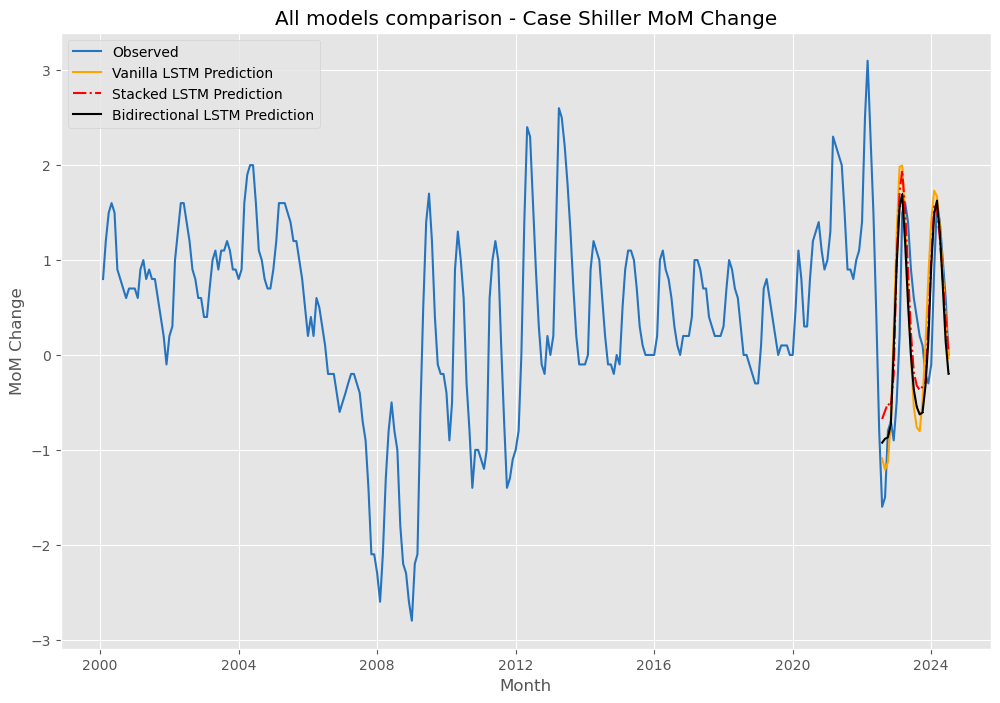

In [78]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data.index,data,label="Observed",color='#2574BF')
#Vanilla LSTM
plt.plot(data[split:].index,final_vanilla,label="Vanilla LSTM Prediction",linestyle= "-", color='orange')
#Stacked LSTM
plt.plot(data[split:].index,final_stacked,label="Stacked LSTM Prediction",linestyle= "-.", color="red")
#Bidirectional LSTM
plt.plot(data[split:].index,final_bidirec,label="Bidirectional LSTM Prediction",marker=',',color='black')
#CNN model
# plt.plot(data[split:].index,final_cnn,label="CNN Prediction",marker="*",color="purple")
plt.title('All models comparison - Case Shiller MoM Change')
plt.xlabel('Month')
plt.ylabel('MoM Change')
plt.legend(loc='upper left')
plt.show()